# 3-Mappillary_image_processer
## Get images from Mapillary to test with V-RoAst
This notebook will be used to download Street View images from Mapillary. The hypothesis is whether we can use crowdsourced data to obtain star ratings, as we propose V-RoAst as ThaiRAP.

### Download images from Mapillary to evaluate if we can use with V-RoAst

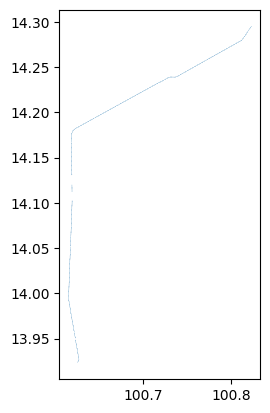

In [2]:
# Get location to download images from Mapillary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the ground truth
ground_truth_path = './Validation.csv'

gt_df = pd.read_csv(ground_truth_path)
#gt_df.head()

#count rows in gt_df
gt_df.shape #519 rows and 87 columns
#pd.count(gt_df)

# get buffer around the points
import geopandas as gpd
from shapely.geometry import Point

gt_df['geometry'] = [Point(xy) for xy in zip(gt_df['Longitude start'], gt_df['Latitude start'])]
gt_gdf = gpd.GeoDataFrame(gt_df, crs='EPSG:4326')
gt_gdf = gt_gdf.to_crs('EPSG:32630')
# 50 meters buffer
gt_gdf['geometry'] = gt_gdf['geometry'].buffer(50)
gt_gdf = gt_gdf.to_crs('EPSG:4326')

#plot the buffered ground truth locations
gt_gdf.plot()
plt.show()


## How to download Street View Images (SVIs) from Mapillary

https://www.mapillary.com/developer/api-documentation

### You need to create an account and get an API key from here: 
https://www.mapillary.com/dashboard/developers


In [4]:
# List of access tokens
tokens = [
    'MLY|7758511440877125|e90f49b83f7d82e705330e2134273261',
    'MLY|7418410821613240|127fffa4dbb8b4141d239ab3204d9c05',
    'MLY|7444886388892663|10980f20ab0c0d9f893a617176f88060',
    'MLY|7276628592459844|90b73ce80badf1b228f5a7926cdadf5b',
    'MLY|7439545039458242|07a5bca78091beba7efe9fe2633a94b9',
    'MLY|7459834177464281|915346214ef20ebed5001c2609ec8f96',
    'MLY|7408208959228513|dd9293764a38e167646f1c426c675a87',
    'MLY|7451125758318383|f1b966cf1a16f338a87d5a25abb86e74',
    'MLY|8129332567096541|581f4758983ab5b8e5ea23e7c77825d2',
    'MLY|7381085931945856|514252b5aabfaf9a31a118dee5661560',
    'MLY|25588830627397030|dd91a9a44a2c11ce0d1aa4ef5ad3cbb5',
    'MLY|7792956824068086|61fcb3d7c0fbd2cd1cf60d370adf6eca',
    'MLY|25427046930276053|aa4027c5d876ddabfe6246fa42ad6a4b',
    'MLY|7521434354545876|803ac38388237000857a22ef0f7e07ad',
    'MLY|7476826549075795|b7a837a4c79ee9afaf6841f3bb1fc488',
    'MLY|7078921468879299|ac8444c10bea23f6be35dbcb0c72cfc0',
    'MLY|7524430764277549|15722ae39947634f984441aa4757b329',
    'MLY|7750296068354005|e0a5bed65793ea0b5a802384d7068eef',
    'MLY|7379006472218282|24d799a1a5c3c5df558445b35c5dd103',
    'MLY|7155416914585782|662612f7c3149b3c78e60872ca48af8b'
]

## Download images from Mapillary

We will download images using *50-metre* buffers of *519 segments* (each segment represents a 100-metre road) to represent the segments.

Since there is no *Road survey date* within the dataset, and the *Coding date* is between *10/12/23 and 23/2/24*, we will assume that roads were surveyed before 2023. Therefore, we will limit the timestamp when downloading images from Mapillary to *1/1/2022*. Moreover, we will use a maximum of 4 images per segment, similar to the ThaiRAP dataset.


In [ ]:
import os
import requests
import mercantile
import json
from vt2geojson.tools import vt_bytes_to_geojson
import datetime
import random
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Set up paths and folders
folder_name = './/image//Mapillary'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Select a random token
selected_token = random.choice(tokens)

# Load the ground truth data and create buffers
ground_truth_path = './/Validation.csv'
gt_df = pd.read_csv(ground_truth_path)
gt_df['geometry'] = [Point(xy) for xy in zip(gt_df['Longitude start'], gt_df['Latitude start'])]
gt_gdf = gpd.GeoDataFrame(gt_df, crs='EPSG:4326')
gt_gdf = gt_gdf.to_crs('EPSG:32630')
gt_gdf['geometry'] = gt_gdf['geometry'].buffer(50)  # 50 meters buffer
gt_gdf = gt_gdf.to_crs('EPSG:4326')

# Headers for image download requests
headers = {'Authorization': f'OAuth {selected_token}'}

# Initialize an empty GeoJSON for output
output = {"type": "FeatureCollection", "features": []}

# Filter date: 1/1/2022
filter_date = datetime.datetime(2022, 1, 1)

# Loop through each buffer in gt_gdf
for idx, buffer in gt_gdf.iterrows():
    bounds = buffer['geometry'].bounds  # Get bounding box [west, south, east, north]
    west, south, east, north = bounds

    # Collect tiles at zoom level 14 within the current buffer
    tiles = list(mercantile.tiles(west, south, east, north, 14))

    image_count = 0  # Counter for images downloaded for this buffer

    # Loop through the tiles and fetch data
    for tile in tiles:
        if image_count >= 4:
            break  # Stop if we've reached the max number of images

        tile_url = f'https://tiles.mapillary.com/maps/vtp/mly1_public/2/{tile.z}/{tile.x}/{tile.y}?access_token={selected_token}'
        response = requests.get(tile_url)
        if response.status_code == 200:
            data = vt_bytes_to_geojson(response.content, tile.x, tile.y, tile.z, layer="image")

            # Process each feature in the geojson
            for feature in data['features']:
                if image_count >= 4:
                    break  # Stop if we've reached the max number of images

                coords = feature['geometry']['coordinates']
                properties = feature['properties']
                lng, lat = coords
                sequence_id = properties['sequence_id']
                image_id = properties['id']
                captured_at = properties['captured_at']
                compass_angle = properties['compass_angle']
                is_pano = properties['is_pano']

                capture_date = datetime.datetime.fromtimestamp(int(captured_at) / 1000)  # assuming captured_at is in milliseconds

                # Ensure the feature is within the current buffer and after the filter date
                if buffer['geometry'].contains(Point(lng, lat)) and capture_date >= filter_date:
                    # Fetch the image URL
                    image_info_url = f'https://graph.mapillary.com/{image_id}?fields=id,thumb_2048_url&access_token={selected_token}'
                    image_info_response = requests.get(image_info_url, headers=headers)
                    if image_info_response.status_code == 200:
                        image_info = image_info_response.json()
                        image_url = image_info['thumb_2048_url']

                        # Download the image and save it with metadata
                        image_response = requests.get(image_url, stream=True)
                        if image_response.status_code == 200:
                            image_path = os.path.join(folder_name, f'{image_id}.jpg')
                            with open(image_path, 'wb') as file:
                                file.write(image_response.content)

                            # Append metadata to output geojson
                            feature['properties'].update({
                                "captured_at": captured_at,
                                "compass_angle": compass_angle,
                                "is_pano": is_pano,
                                "image_url": image_url  # Add image URL to the properties
                            })
                            output['features'].append(feature)

                            image_count += 1  # Increment image counter

# Save the GeoJSON object to a file
geojson_path = os.path.join(folder_name, 'mapillary_metadata.geojson')
with open(geojson_path, 'w') as file:
    json.dump(output, file, indent=4)  # Use indent=4 for better readability

print(f"GeoJSON data saved to {geojson_path}")


GeoJSON data saved to C:/Users/ucesnjo/OneDrive - University College London/General - AAAI2025/image/Mapillary\mapillary_metadata.geojson


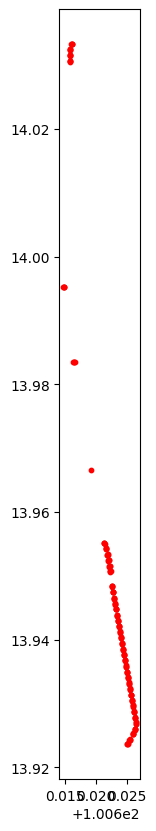

Number of buffered points with images: 167


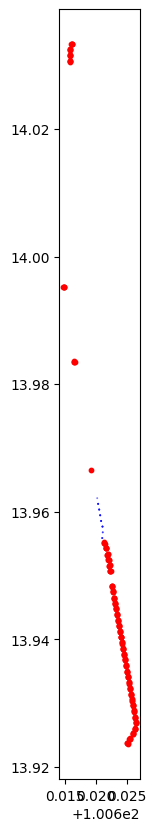

In [7]:
# plot geospatial data
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoJSON file
geojson_path = './/image//Mapillary//mapillary_metadata.geojson'
gdf = gpd.read_file(geojson_path)

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, markersize=10, color='red')
plt.show()


# Load the ground truth data and create buffers
ground_truth_path = './Validation.csv'
gt_df = pd.read_csv(ground_truth_path)
gt_df['geometry'] = [Point(xy) for xy in zip(gt_df['Longitude start'], gt_df['Latitude start'])]
gt_gdf = gpd.GeoDataFrame(gt_df, crs='EPSG:4326')
gt_gdf = gt_gdf.to_crs('EPSG:32630')
gt_gdf['geometry'] = gt_gdf['geometry'].buffer(50)  # 50 meters buffer
gt_gdf = gt_gdf.to_crs('EPSG:4326')

# Count the number of buffered points from gt_df that have at least one image in gdf
buffered_points_with_images = 0
for idx, buffer in gt_gdf.iterrows():
    if gdf.intersects(buffer['geometry']).any():
        buffered_points_with_images += 1

print(f"Number of buffered points with images: {buffered_points_with_images}")

# plot the buffered ground truth locations that have images
fig, ax = plt.subplots(figsize=(10, 10))
gt_gdf[gt_gdf.index.isin(gdf.index)].plot(ax=ax, color='blue', alpha=0.5)
gdf.plot(ax=ax, markersize=10, color='red')
plt.show()

## Convert paronamic images to front view

we used Equirec2Perspec function (https://github.com/fuenwang/Equirec2Perspec) to convert/crop 360-view to front view image

Process all images using 60, 0, 0, 1200, 1600 then we will correct some error angle later

In [ ]:
import os
import cv2 
import Equirec2Perspec as E2P 

# Set the input and output paths
input_path = './/Mapillary'
output_path = './/Mapillary_processed'

# Create the output folder if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Process each image in the input path
for filename in os.listdir(input_path):
    if filename.endswith('.jpg'):
        # Load the equirectangular image
        image_path = os.path.join(input_path, filename)
        equ = E2P.Equirectangular(image_path)
        
        # Specify the parameters for perspective transformation
        fov = 100
        theta = 0
        phi = 20
        height = 1200
        width = 1600
        
        # Perform perspective transformation
        img = equ.GetPerspective(fov, theta, phi, height, width)
        
        # Save the processed image in the output folder
        output_filename = os.path.join(output_path, filename)
        cv2.imwrite(output_filename, img)

print("All images processed and saved in the 'Mapillary_processed' folder.")


All images processed and saved in the 'Mapillary_processed' folder.


### Maunally convert images that are not in the correct angle
change equ.GetPerspective(FOV, theta, phi, 1200, 1600)
- FOV unit is degree 
- theta is z-axis angle(right direction is positive, left direction is negative)
- phi is y-axis angle(up direction positive, down direction negative)
- height and width is output image dimension (1200,1600)


True

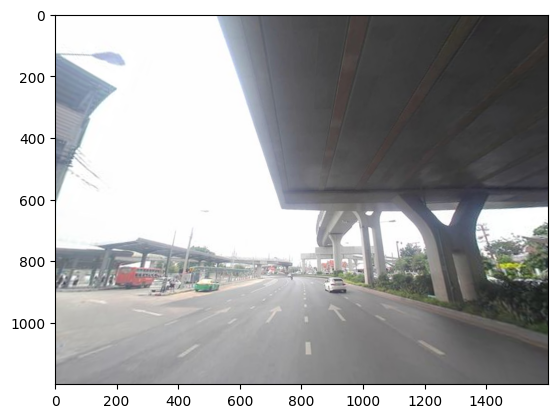

In [ ]:
import os
import cv2 
import Equirec2Perspec as E2P 
import matplotlib.pyplot as plt

Mapillary_name = "753769772570590.jpg"
image_path = f'./image/Mapillary/{Mapillary_name}'
equ = E2P.Equirectangular(image_path)    # Load equirectangular image
    
    #
    # FOV unit is degree 
    # theta is z-axis angle(right direction is positive, left direction is negative)
    # phi is y-axis angle(up direction positive, down direction negative)
    # height and width is output image dimension 
    #
img = equ.GetPerspective(100, 30, 20, 1200, 1600) # Specify parameters(FOV, theta, phi, height, width)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#save
output_path = f'./image/Mapillary_processed//{Mapillary_name}'
cv2.imwrite(output_path)
import pandas as pd
import os
import shutil

# Define the path to the merged_gdf file
merged_gdf_path = './image/Mapillary_processed/mapillary.csv'

# Read the merged_gdf file into a DataFrame
merged_gdf = pd.read_csv(merged_gdf_path)

# Define the folder where images are stored
folder_path = os.path.dirname('./image/Mapillary_processed/')

# Convert 'id' column to string to avoid any scientific notation or formatting issues
merged_gdf['id'] = merged_gdf['id'].apply(lambda x: str(int(x)))

# Iterate over each row and create new images
for index, row in merged_gdf.iterrows():
    old_image_name = row['id'] + '.jpg'  # Assuming the images have a .jpg extension
    new_image_name = str(row['image_id']) + '.jpg'
    old_image_path = os.path.join(folder_path, old_image_name)
    new_image_path = os.path.join(folder_path, new_image_name)
    
    try:
        shutil.copy(old_image_path, new_image_path)
        print(f"Created new image: {new_image_name}")
    except FileNotFoundError:
        print(f"File {old_image_name} not found. Skipping.")
    except Exception as e:
        print(f"Error creating new image: {new_image_name}: {e}")

print(f"Image creation process completed for folder: {folder_path}")


### Rename mapillary images 


In [ ]:
import pandas as pd
import os
import shutil

# Define the path to the merged_gdf file
merged_gdf_path = './mapillary.csv'

# Read the merged_gdf file into a DataFrame
merged_gdf = pd.read_csv(merged_gdf_path)

# Define the folder where images are stored
folder_path = os.path.dirname('./Mapillary_processed/')

# Convert 'id' column to string to avoid any scientific notation or formatting issues
merged_gdf['id'] = merged_gdf['id'].apply(lambda x: str(int(x)))

# Iterate over each row and create new images
for index, row in merged_gdf.iterrows():
    old_image_name = row['id'] + '.jpg'  # Assuming the images have a .jpg extension
    new_image_name = str(row['image_id']) + '.jpg'
    old_image_path = os.path.join(folder_path, old_image_name)
    new_image_path = os.path.join(folder_path, new_image_name)
    
    try:
        shutil.copy(old_image_path, new_image_path)
        print(f"Created new image: {new_image_name}")
    except FileNotFoundError:
        print(f"File {old_image_name} not found. Skipping.")
    except Exception as e:
        print(f"Error creating new image: {new_image_name}: {e}")

print(f"Image creation process completed for folder: {folder_path}")
